In [1]:
# Data from Sibur Himprom
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import warnings
from platform import python_version
RAND_STATE = 2007
TEST_SIZE = 0.25
# sklearn
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error, r2_score, max_error, make_scorer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.inspection import permutation_importance
# OTHER
import optuna
from lightgbm import LGBMRegressor
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import ImportanceCutoffSelector, ModelBasedImportanceEstimator
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.automl.blend import WeightedBlender
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML

In [2]:
!pip install -r requirements.txt

     ---------------------------------------- 8.4/8.4 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: scikit_learn
    Found existing installation: scikit-learn 1.1.2
    Uninstalling scikit-learn-1.1.2:
      Successfully uninstalled scikit-learn-1.1.2


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\oleg\\AppData\\Roaming\\Python\\Python39\\site-packages\\~klearn\\.libs\\vcomp140.dll'
Consider using the `--user` option or check the permissions.



In [2]:
df_0 = pd.read_csv('df_hw1_Anonymized.csv', index_col='Время отбора', parse_dates=['Время отбора'])

In [3]:
df_0.describe()

,target,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_332,x_333,x_334,x_335,x_336,x_337,x_338,x_339,x_340,x_341
count,14785.000000,14785.000000,14785.000000,14785.000000,14785.0,14785.000000,14785.000000,14785.000000,14785.0,14785.000000,...,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000
mean,589.844086,7.288612,150.426058,99.568518,0.0,4.493195,3.611634,4.689872,0.0,5.322284,...,0.431160,58.941189,3.979873,0.503385,0.038904,0.014526,0.008261,0.004281,0.003449,1.767078
std,380.034395,1.888545,4.948526,0.983532,0.0,2.508940,2.032597,2.468002,0.0,5.078261,...,0.097756,8.985394,0.743686,0.381957,0.049095,0.028104,0.023179,0.015980,0.013325,0.642238
min,3.978624,3.745066,141.106100,96.046480,0.0,0.351661,-0.097949,0.089729,0.0,-0.012385,...,0.339000,34.813758,1.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578530
25%,278.637500,5.577129,146.291100,99.005810,0.0,3.265112,3.446419,4.637184,0.0,1.111428,...,0.399000,50.109945,3.690000,0.080000,0.020000,0.000000,0.000000,0.000000,0.000000,1.109597
50%,589.331500,7.652292,150.864900,99.650110,0.0,4.893831,4.589209,5.792949,0.0,3.790610,...,0.409000,60.007335,3.950000,0.590000,0.030000,0.000000,0.000000,0.000000,0.000000,1.687319
75%,840.316700,8.411092,153.449300,100.219000,0.0,6.103675,4.914419,6.342236,0.0,8.318812,...,0.451000,67.367930,4.600000,0.840000,0.050000,0.020000,0.000000,0.000000,0.000000,2.389740
max,1782.959000,11.963890,166.303300,102.268100,0.0,14.199789,5.604282,7.121434,0.0,17.005189,...,1.261000,83.077478,11.290000,2.650000,0.660000,0.240000,0.240000,0.130000,0.080000,6.808222


# EDA and data preprocessing

In [4]:
features = df_0.columns[1:]
tg = df_0.columns[0]

tg_series = df_0[tg]

In [5]:
selector_1 = SelectPercentile(mutual_info_regression, percentile=95).fit(df_0[features], df_0[tg])

In [6]:
df = pd.DataFrame(selector_1.transform(df_0[features]), columns=selector_1.get_feature_names_out(features), index=df_0.index)
df[tg] = tg_series

In [7]:
df.describe()

,x_0,x_1,x_2,x_4,x_5,x_6,x_8,x_9,x_10,x_12,...,x_329,x_330,x_331,x_332,x_333,x_334,x_335,x_336,x_341,target
count,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,...,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000,14785.000000
mean,7.288612,150.426058,99.568518,4.493195,3.611634,4.689872,5.322284,3.833948,4.429845,0.956752,...,5.392012,747.704319,62.748777,0.431160,58.941189,3.979873,0.503385,0.038904,1.767078,589.844086
std,1.888545,4.948526,0.983532,2.508940,2.032597,2.468002,5.078261,2.148046,2.326470,0.499027,...,12.005768,7.369793,17.274170,0.097756,8.985394,0.743686,0.381957,0.049095,0.642238,380.034395
min,3.745066,141.106100,96.046480,0.351661,-0.097949,0.089729,-0.012385,-0.049958,0.067639,0.000000,...,-26.537302,721.839966,13.477937,0.339000,34.813758,1.880000,0.000000,0.000000,0.578530,3.978624
25%,5.577129,146.291100,99.005810,3.265112,3.446419,4.637184,1.111428,3.971498,4.236131,1.099872,...,-3.677513,743.494202,49.208202,0.399000,50.109945,3.690000,0.080000,0.020000,1.109597,278.637500
50%,7.652292,150.864900,99.650110,4.893831,4.589209,5.792949,3.790610,4.867854,5.332766,1.177489,...,5.584920,748.078308,67.379364,0.409000,60.007335,3.950000,0.590000,0.030000,1.687319,589.331500
75%,8.411092,153.449300,100.219000,6.103675,4.914419,6.342236,8.318812,5.188269,5.842798,1.239486,...,15.163492,752.579102,76.921432,0.451000,67.367930,4.600000,0.840000,0.050000,2.389740,840.316700
max,11.963890,166.303300,102.268100,14.199789,5.604282,7.121434,17.005189,5.944522,7.053470,1.504951,...,30.023809,767.260559,91.429893,1.261000,83.077478,11.290000,2.650000,0.660000,6.808222,1782.959000


In [8]:
regected_features = []
for i in features:
    if i not in selector_1.get_feature_names_out(features): regected_features.append(i)
regected_features    

['x_3',
 'x_7',
 'x_11',
 'x_34',
 'x_39',
 'x_96',
 'x_199',
 'x_236',
 'x_242',
 'x_243',
 'x_280',
 'x_281',
 'x_288',
 'x_289',
 'x_337',
 'x_338',
 'x_339',
 'x_340']

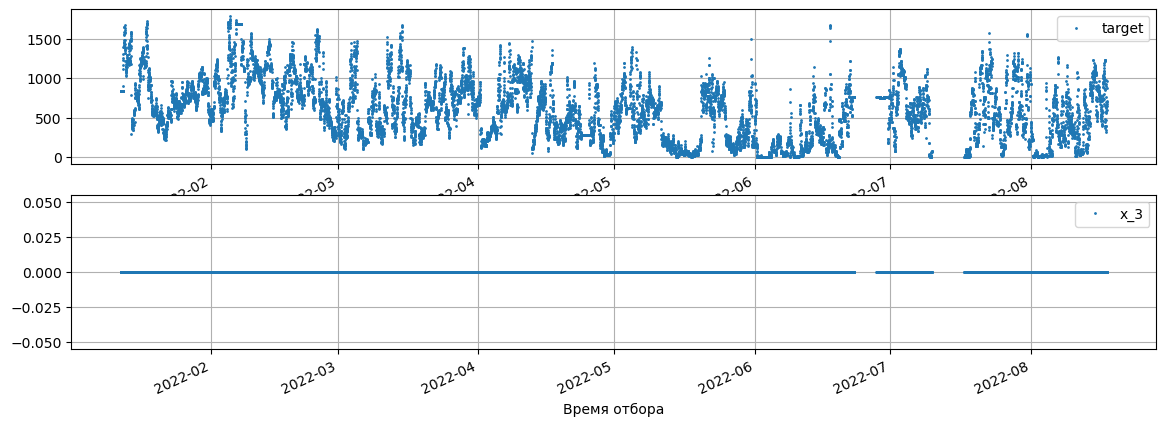

In [9]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(2,1, figsize=(14,5))
df_0[tg].plot(marker='o', markersize=1, linestyle = 'none', ax=ax[0])
df_0[regected_features[0]].plot(marker='o', markersize=1, linestyle = 'none', ax=ax[1])
plt.xticks(rotation=25)  
ax[0].legend() 
ax[1].legend() 
ax[0].grid() 
ax[1].grid() 
plt.show()

## Train test split and scaling

In [10]:
df_train, df_test = train_test_split(df, shuffle=False, random_state=RAND_STATE, test_size=TEST_SIZE)
X_train, X_test, y_train, y_test = df_train.drop([tg], axis=1), df_test.drop([tg], axis=1), df_train[[tg]], df_test[[tg]]
# X_train, X_test, y_train, y_test = train_test_split(df_1.drop([tg], axis=1), df_1[[tg]], shuffle=False, random_state=RAND_STATE, test_size=TEST_SIZE)

In [11]:
# scaler = RobustScaler(quantile_range=(5.0, 95.0))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline (PLS)

In [12]:
def f_relative_error(y: np.ndarray, y_pred: np.ndarray, mode=0):
    error = []
    for i, j in zip(y, y_pred):
        error.append(float((j-i)/i))
    if mode == 0: return(np.mean(error)+2*np.std(error, ddof=1))
    else: return(error)

def MDAPE(actual,predicted,sample_weight=None): # Median Absolute Percentage Error
    return(np.median((np.abs(np.subtract(actual, predicted)/ actual))) * 1)

def f_MRE_0(y: np.ndarray, y_pred: np.ndarray, mode=0): #CO
    error = []
    for i, j in zip(y, y_pred):
        if (0<=i<=20) & (0<=j<=20): base = 20 
        
        if (0<=i<=75) & (0<=j<=75): base = 75 

        elif (0<=i<=500) & (0<=j<=100): base = 100
        elif (0<=i<=500) & (100<j<=500): base = i
                
        elif (0<=i<=1000) & (0<j<=500): base = 500
        elif (0<=i<=1000) & (500<j<=1000): base = i
                
        else:  base = i   
        error.append(float((j-i)/base))
    if mode == 0: return(np.mean(error)+2*np.std(error, ddof=1))
    else: return(error)

def f_metrics(y_train: pd.DataFrame, y_train_pred: pd.DataFrame, y_test: pd.DataFrame, y_test_pred: pd.DataFrame, MRE) -> pd.DataFrame:
    MAE_train, MAE_test = median_absolute_error(y_train, y_train_pred), median_absolute_error(y_test, y_test_pred) # mae
    RMSE_train, RMSE_test = mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred,  squared=False) #rmse
    MAPE_train, MAPE_test = mean_absolute_percentage_error(y_train, y_train_pred), mean_absolute_percentage_error(y_test, y_test_pred) # MAPE
    MDAPE_train, MDAPE_test = MDAPE(y_train, y_train_pred), MDAPE(y_test, y_test_pred)
    R2_train, R2_test = r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)
    Median_reduced_error_train, Median_reduced_error_test = MRE(y_train, y_train_pred), MRE(y_test, y_test_pred)
    relative_error_train, relative_error_test = f_relative_error(y_train, y_train_pred), f_relative_error(y_test, y_test_pred)
    return(pd.DataFrame({'MAE':[MAE_train, MAE_test], 'RMSE':[RMSE_train,RMSE_test], 'MAPE':[MAPE_train, MAPE_test], 'MDAPE':[MDAPE_train, MDAPE_test], 
                         'R2': [R2_train, R2_test], 'MRE': [Median_reduced_error_train, Median_reduced_error_test], 'Relative_error':[relative_error_train, relative_error_test]}, index=['Train','Test']))

def f_fig(y_test,y_test_pred,y_train,y_train_pred,tg):
    plt.rcParams.update({'font.size': 10})
    fig, ax = plt.subplots(1,1, figsize=(14,5))
    y_test.plot(marker='o',markersize=0.5, linestyle = 'None', ax=ax, label='y_test', c = 'black')
    y_train.plot(marker='o',markersize=0.5, linestyle = 'None', ax=ax, label='y_train', c = 'black')
    y_test_pred.plot(marker='o',markersize=0.5,linestyle = 'None',c='r',ax=ax,label='y_test_pred')
    y_train_pred.plot(marker='o',markersize=0.5,linestyle = 'None',c='g',ax=ax,label='y_train_pred')
    plt.xticks(rotation=25)  
    plt.ylabel(tg)
    plt.legend() 
    plt.grid()         
    plt.show()  

In [13]:
%%time
param_grid = { 
    'n_components':  [
                      int(X_train.shape[1]*0.1),
                      int(X_train.shape[1]*0.2),
                      int(X_train.shape[1]*0.5),
                      int(X_train.shape[1]*0.8),
                      int(X_train.shape[1]*0.9), 
                      X_train.shape[1]-1]
}
model = PLSRegression(scale=False, max_iter=1000, tol=1e-06) 
grid = GridSearchCV(model, param_grid=param_grid, verbose=1, 
                    cv=3, 
                    n_jobs=-1,
                    #scoring=make_scorer(f_relative_error, greater_is_better=False), 
                    #scoring='r2',
                    scoring='neg_mean_squared_error'
                    #scoring='neg_mean_absolute_percentage_error'
                   )

grid.fit(X_train_scaled, y_train.values)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: -2388809.5398457632 with param: {'n_components': 64}
CPU times: total: 3.58 s
Wall time: 32.9 s


In [14]:
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,5.985914,0.040185,0.036334,0.001244,64,{'n_components': 64},-4.191762e+06,-2.774194e+06,-2.004722e+05,-2.388810e+06,1.652067e+06,1
0,2.792067,0.008498,0.042670,0.006651,32,{'n_components': 32},-5.570879e+06,-1.382528e+06,-2.546677e+05,-2.402692e+06,2.287076e+06,2
2,15.458816,1.046849,0.039334,0.004189,162,{'n_components': 162},-1.510052e+06,-6.399539e+06,-1.582977e+05,-2.689296e+06,2.680950e+06,3
3,22.878536,0.705118,0.030030,0.004978,259,{'n_components': 259},-3.349716e+07,-5.987415e+06,-2.021675e+05,-1.322892e+07,1.452512e+07,4
4,22.531996,0.559071,0.015011,0.002927,291,{'n_components': 291},-3.980525e+07,-5.983308e+06,-2.018509e+05,-1.533014e+07,1.746673e+07,5
5,20.762641,0.128241,0.009669,0.002358,323,{'n_components': 323},-3.114852e+33,-2.802732e+33,-1.807068e+33,-2.574884e+33,5.576801e+32,6


In [15]:
y_train_pred, y_test_pred = pd.DataFrame(grid.predict(X_train_scaled), index=y_train.index, columns=y_test.columns), pd.DataFrame(grid.predict(X_test_scaled), index=y_test.index, columns=y_test.columns)
y_test_pred[y_test_pred<0], y_train_pred[y_train_pred<0] = 0, 0
print(f_metrics(y_train.values, y_train_pred.values, y_test.values, y_test_pred.values, f_MRE_0))

              MAE        RMSE      MAPE     MDAPE        R2        MRE  \
Train   65.490013  113.046040  0.406623  0.128814  0.914201   2.469435   
Test   447.291500  543.625542  4.719786  0.980917 -1.360253  30.833334   

       Relative_error  
Train        3.282527  
Test        30.859645  


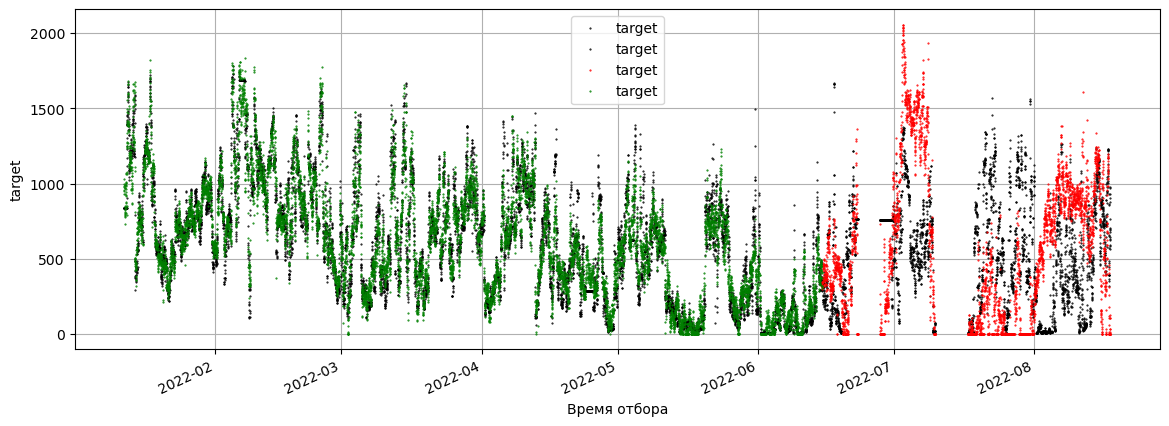

In [16]:
f_fig(y_test,y_test_pred,y_train,y_train_pred,tg)

In [18]:
r = permutation_importance(grid, X_train_scaled, y_train,
                         n_repeats=5,
                           random_state=RAND_STATE)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

x_25    1694956.107 +/- 26617.184
x_165   984485.927 +/- 11366.842
x_189   921552.005 +/- 7798.104
x_169   917736.296 +/- 10238.971
x_191   831734.065 +/- 5544.097
x_84    740633.037 +/- 6922.598
x_246   705293.683 +/- 8688.763
x_164   590874.690 +/- 6593.966
x_194   587211.858 +/- 5209.836
x_23    567362.670 +/- 7783.447
x_100   555447.799 +/- 3936.241
x_82    468353.768 +/- 5584.007
x_27    431189.093 +/- 5972.830
x_111   421250.775 +/- 2924.430
x_24    346980.438 +/- 4691.465
x_14    320903.134 +/- 5549.555
x_312   318929.478 +/- 2286.275
x_116   288877.023 +/- 2930.698
x_141   272959.663 +/- 5005.713
x_83    267466.534 +/- 2725.913
x_51    264481.550 +/- 3031.459
x_245   252711.632 +/- 3116.757
x_140   236308.612 +/- 3077.506
x_21    228215.032 +/- 3136.024
x_145   223122.033 +/- 2420.302
x_90    214274.326 +/- 2711.152
x_142   196355.297 +/- 3622.078
x_113   191383.803 +/- 1415.227
x_102   185021.135 +/- 1454.471
x_58    166601.926 +/- 1743.332
x_50    138303.203 +/- 1868.652
x_72

# lightGBM + Optuna

In [33]:
# EARLY_STOPPING_ROUND = 25
def objective(trial):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 300]),    
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20), # the maximum limit to num_leaves should be 2^(max_depth), impacts the learning in LGBM more than max_depth. This means you need to specify a more conservative search range like (20, 3000) 
        "max_depth": trial.suggest_int("max_depth", 3, 12),  
     
        "min_child_samples":  trial.suggest_categorical("min_child_samples", [20]),

        "reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=50),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=50),
          
        'random_state' : RAND_STATE,
        'n_jobs' : -1,
        'metric': 'mean_squared_error',
        'linear_tree': True
        # root_mean_squared_error
        # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        # "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        # "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        # "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1), 
    }

    regressor = LGBMRegressor(**param_grid)
    loss = cross_val_score(estimator=regressor, X=X_train_scaled, y=y_train, 
                           cv = 3, 
                           #cv=TimeSeriesSplit(n_splits=4),
                           scoring = 'neg_mean_squared_error',
                           # neg_mean_squared_error, neg_root_mean_squared_error
                           n_jobs = -1
                           #scoring=make_scorer(MDAPE,greater_is_better=False),
                          )
    
    #loss = mean_squared_error(y_eval, regressor.predict(X_eval.copy()),squared=False)
    return loss.mean()

In [34]:
%%time
study = optuna.create_study(study_name=f'lgbm_seed_{RAND_STATE}', direction ='maximize')
study.optimize(objective, n_trials=100, timeout=60*60*1) # seconds

CPU times: total: 3.72 s
Wall time: 10min 22s


In [35]:
print(f"\tBest value (metric): {study.best_value:.5f}")
print(f"\tBest params: {study.best_params}")

	Best value (metric): -13110668.07249
	Best params: {'n_estimators': 100, 'learning_rate': 0.03505739853506054, 'num_leaves': 960, 'max_depth': 5, 'min_child_samples': 20, 'reg_alpha': 50, 'reg_lambda': 50}


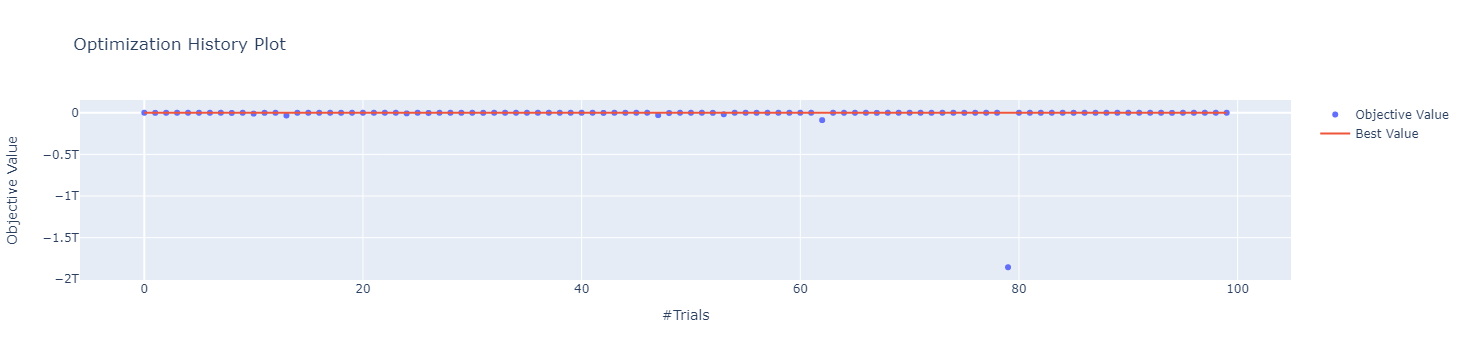

In [36]:
optuna.visualization.plot_optimization_history(study)

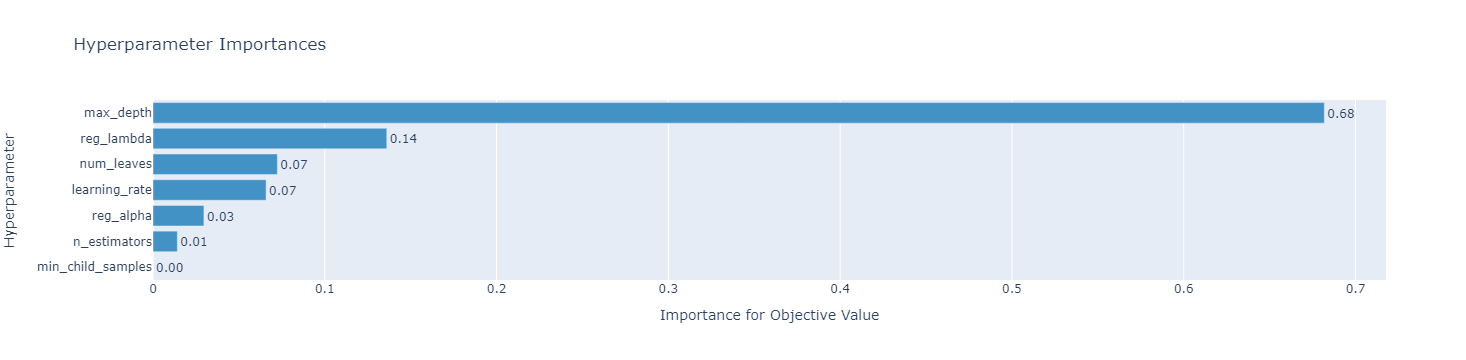

In [37]:
optuna.visualization.plot_param_importances(study)

In [38]:
%%time
optimized_regressor = LGBMRegressor(
        n_estimators = study.best_params['n_estimators'], 
        learning_rate = study.best_params["learning_rate"],
        
        num_leaves = study.best_params["num_leaves"],
        max_depth = study.best_params["max_depth"],  
     
        min_child_samples = study.best_params["min_child_samples"],

        reg_alpha = study.best_params["reg_alpha"],
        reg_lambda = study.best_params["reg_lambda"],
    
        verbosity = 1,
        metric = 'root_mean_squared_error'
    # mean_absolute_percentage_error, mean_absolute_error    
)

optimized_regressor.fit(X_train_scaled, y_train,
                        #   eval_set=[(X_eval, y_eval)],
                        #early_stopping_rounds=EARLY_STOPPING_ROUND,
                        #use_best_model=True
                       )

C:\Users\oleg\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80710
[LightGBM] [Info] Number of data points in the train set: 11088, number of used features: 324
[LightGBM] [Info] Start training from score 611.489318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

LGBMRegressor(learning_rate=0.03505739853506054, max_depth=5,
              metric='root_mean_squared_error', num_leaves=960, reg_alpha=50,
              reg_lambda=50, verbosity=1)

              MAE        RMSE      MAPE     MDAPE        R2        MRE  \
Train   54.378114  100.604867  0.563279  0.101629  0.932047   1.864112   
Test   268.462860  337.805778  4.781908  0.453754  0.088634  30.496348   

       Relative_error  
Train        4.323558  
Test        30.502902  


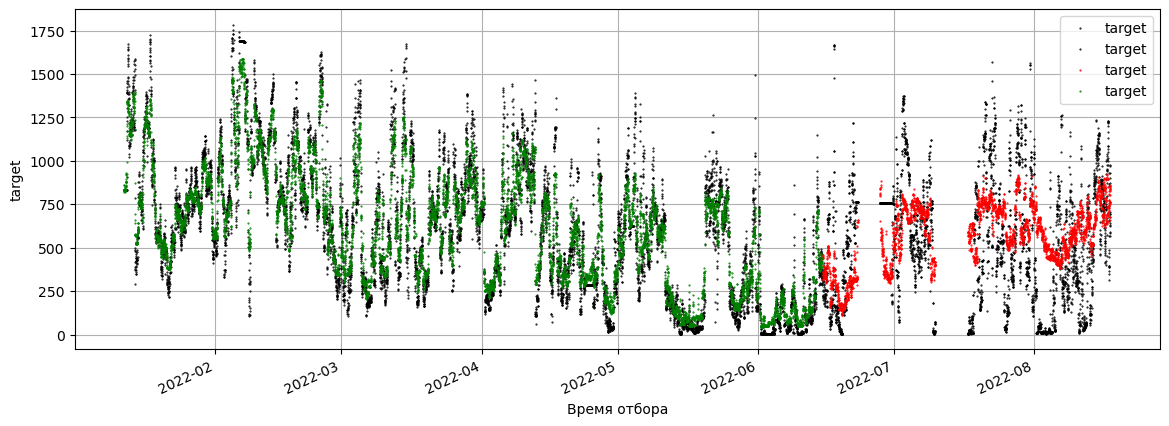

CPU times: total: 1.52 s
Wall time: 732 ms


In [39]:
%%time
y_train_pred, y_test_pred = pd.DataFrame(optimized_regressor.predict(X_train_scaled), index=y_train.index, columns=y_test.columns), pd.DataFrame(optimized_regressor.predict(X_test_scaled), index=y_test.index, columns=y_test.columns)
y_test_pred[y_test_pred<0], y_train_pred[y_train_pred<0] = 0, 0
print(f_metrics(y_train.values, y_train_pred.values, y_test.values, y_test_pred.values, f_MRE_0))

f_fig(y_test,y_test_pred,y_train,y_train_pred,tg)

In [26]:
r = permutation_importance(optimized_regressor, X_train_scaled, y_train,
                         n_repeats=3,
                           random_state=RAND_STATE)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8} "
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

x_317    0.099 +/- 0.002
x_304    0.088 +/- 0.001
x_306    0.070 +/- 0.001
x_24     0.054 +/- 0.001
x_300    0.053 +/- 0.000
x_85     0.041 +/- 0.001
x_316    0.040 +/- 0.000
x_9      0.030 +/- 0.001
x_245    0.025 +/- 0.000
x_204    0.025 +/- 0.000
x_206    0.023 +/- 0.001
x_14     0.015 +/- 0.000
x_29     0.013 +/- 0.000
x_26     0.012 +/- 0.000
x_132    0.011 +/- 0.000
x_164    0.010 +/- 0.000
x_152    0.010 +/- 0.000
x_25     0.009 +/- 0.000
x_310    0.009 +/- 0.000
x_13     0.009 +/- 0.000
x_211    0.008 +/- 0.000
x_36     0.007 +/- 0.000
x_228    0.007 +/- 0.000
x_144    0.006 +/- 0.000
x_246    0.006 +/- 0.000
x_153    0.006 +/- 0.000
x_166    0.006 +/- 0.000
x_65     0.006 +/- 0.000
x_165    0.006 +/- 0.000
x_155    0.006 +/- 0.000
x_31     0.006 +/- 0.000
x_8      0.005 +/- 0.000
x_308    0.005 +/- 0.000
x_83     0.004 +/- 0.000
x_200    0.004 +/- 0.000
x_201    0.004 +/- 0.000
x_49     0.004 +/- 0.000
x_198    0.003 +/- 0.000
x_10     0.003 +/- 0.000
x_224    0.003 +/- 0.000


# LAMA: LightAutoML (SBER)

In [27]:
N_THREADS= 6
TIMEOUT= 60*20 # в секундах

In [28]:
%%time
task = Task(name = 'reg', loss = 'mse') # mape, rmsle, quantile, mse
roles = { 'target': tg }
automl = TabularUtilizedAutoML(task=task, timeout=TIMEOUT, cpu_limit=N_THREADS, 
                               reader_params={'n_jobs':N_THREADS,'cv':3,'random_state': RAND_STATE},
                               general_params = {'cv':3, 'use_algos': [['linear_l2','cb_tuned', 'lgb_tuned']]})

CPU times: total: 156 ms
Wall time: 28 ms


In [29]:
automl.fit_predict(df_train, roles = roles, verbose=1)

[11:19:54] Start automl utilizator with listed constraints:
[11:19:54] - time: 1200.00 seconds
[11:19:54] - CPU: 6 cores
[11:19:54] - memory: 16 GB

[11:19:54] If one preset completes earlier, next preset configuration will be started

[11:19:54] ==================================================
[11:19:54] Start 0 automl preset configuration:
[11:19:54] C:\Users\oleg\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[11:19:54] Stdout logging level is INFO.
[11:19:54] Task: reg

[11:19:54] Start automl preset with listed constraints:
[11:19:54] - time: 1200.00 seconds
[11:19:54] - CPU: 6 cores
[11:19:54] - memory: 16 GB

[11:19:54] Train data shape: (11088, 325)

[11:20:04] Layer 1 train process start. Time left 1190.02 secs
[11:20:05] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:20:55] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. 

array([[830.68176],
       [846.6897 ],
       [825.3706 ],
       ...,
       [337.4569 ],
       [337.86768],
       [352.93625]], dtype=float32)

In [30]:
%%time
y_train_pred_AUTOML = automl.predict(df_train)
y_test_pred_AUTOML = automl.predict(df_test)
print(f'Prediction for df_test:\n{y_test_pred_AUTOML}\nShape={y_test_pred_AUTOML.shape}')

Prediction for df_test:
array([[350.38132],
       [344.1684 ],
       [351.9545 ],
       ...,
       [421.69073],
       [417.26624],
       [428.82147]], dtype=float32)
Shape=(3697, 1)
CPU times: total: 27.4 s
Wall time: 6.46 s


              MAE        RMSE      MAPE     MDAPE        R2        MRE  \
Train   12.422599   32.855723  0.077013  0.026476  0.992752   0.391426   
Test   262.545155  336.857777  3.846855  0.474746  0.093742  23.685225   

       Relative_error  
Train        0.538791  
Test        23.697269  


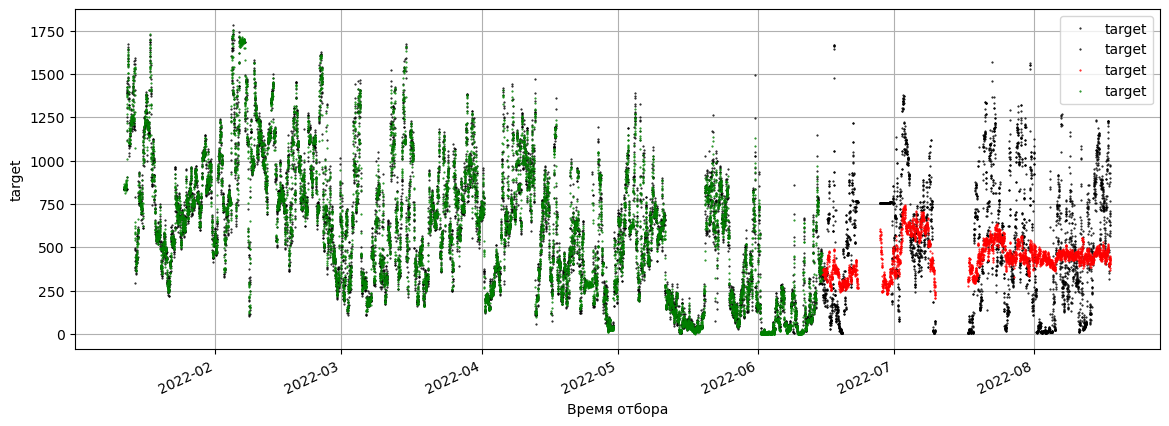

CPU times: total: 641 ms
Wall time: 644 ms


In [31]:
%%time
y_train_pred, y_test_pred = pd.DataFrame(y_train_pred_AUTOML.data[:, 0], index=y_train.index, columns=y_test.columns), pd.DataFrame(y_test_pred_AUTOML.data[:, 0], index=y_test.index, columns=y_test.columns)
y_test_pred[y_test_pred<0], y_train_pred[y_train_pred<0] = 0, 0
print(f_metrics(y_train.values, y_train_pred.values, y_test.values, y_test_pred.values, f_MRE_0))

f_fig(y_test,y_test_pred,y_train,y_train_pred,tg)

In [32]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	1.00000 * 1 averaged models with config = "C:\Users\oleg\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.10445 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.51414 * (1 averaged models Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM) +
			 0.38141 * (3 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost) 





In [ ]:
# fast_fi = automl.get_feature_scores('fast', silent = False) 
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize=(20,10),grid=True)

# Conclusion
Auto Ml methods provide fast API and good results and can be considerable for usage. 
But problem of overfeating raise, as you can see. To investigate such problem additional time is needed.
Despite the small number of lines of code, to build the pipeline the author spent quite a long time, as each API has own syntax.